==============================================================================================
# Practicum 6 

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline: December 22th, 23:00 h**

==============================================================================================

## Imports

In [1]:
from time import time
import os

import numpy as np
from numpy import unique
import matplotlib.pyplot as plt

import skimage
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import io

# Split dataset into training and test
from sklearn.model_selection import train_test_split 

### FACE DETECTION
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.transform import integral_image

### FACE RECOGNITION
# Load the dataset
from sklearn.datasets import fetch_lfw_people 
# Classification and results
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

### What is a Haar-like feature?

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="notebook_images/haar-like.PNG" width=400, height=200>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="notebook_images/haar-like1.PNG" width=500, height=300>


A real application would be:

<img src="notebook_images/face.PNG" width=300, height=300>


To describe the face, we can apply convolutions with Haar features. What alternative to the convolution with Haar-features, do you know?


In [2]:
def show_images(imgs, titles, n_rows, n_columns):
    """
    Creates a grid and visualize in it multiple images.
    """
    fig = plt.figure(figsize=(10, 7))

    for (i, img), img_title in zip(enumerate(imgs), titles):
        fig.add_subplot(n_rows, n_columns, i+1)

        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(img_title)

### 1. Building integral image

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="notebook_images/integral_image.PNG" width=250, height=250>

An example :

<img src="notebook_images/integral_image1.PNG" width=350, height=250>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

**1.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array. The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

Try your function using a `5x5` random grayscale image. Visualize both the original random image and the integral one.

In [3]:
def to_integral_image(img_array):

    row_sum = np.zeros(img_array.shape)
    # we need to add an additional row and column  
    integral_image_arr = np.zeros((img_array.shape[0] + 1, img_array.shape[1] + 1))

    for x in range(img_array.shape[1]):
        for y in range(img_array.shape[0]):
            # Sum the preview value and the actual value
            row_sum[y, x] = row_sum[y-1, x] + img_array[y, x]
            #In the next value we save the value of the next column + the actual value from row sum
            integral_image_arr[y+1, x+1] = integral_image_arr[y+1, x] + row_sum[y, x]
            
    return integral_image_arr

To make sure that the values of the integral image are correct, compute the following tests:

 - `img_array.sum() == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

In [4]:
img_array = np.random.randint(1, 10 ,size=(5,5))
ii_img_array = to_integral_image(img_array)

assert img_array.sum() == ii_img_array[-1,-1]
assert img_array[0,:].sum() == ii_img_array[1,-1]

**1.2** Let's check in real images. Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

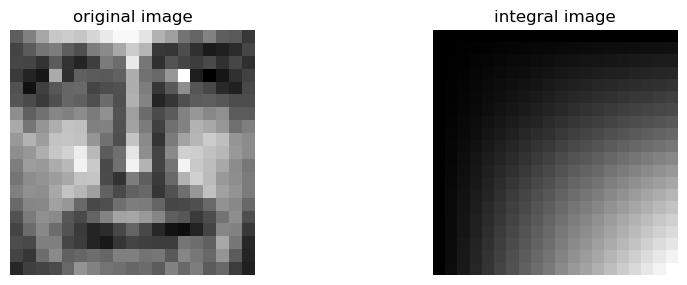

In [5]:
from skimage.io import imread

img = imread('./faces/face00001.png')
int_img = to_integral_image(img)

assert img_array.sum() == ii_img_array[-1,-1]
assert img_array[0,:].sum() == ii_img_array[1,-1]

show_images(
    imgs=[img, int_img],
    titles=['original image', 'integral image'],
    n_rows=2,
    n_columns=2
)

What do the following lines mean? How can you explain this?

- `img_array.sum() == ii_img_array[-1,-1]`
- `img_array[0,:].sum() == ii_img_array[1,-1]`
- `ii_img_array[0,-1].sum() == 0`
 

- `img_array.sum() == ii_img_array[-1,-1]`

This line ensures that the sum of all the pixel values in the original image equals the value from the integral image's rightmost column and lowermost row, whose value must be the sum of all the pixel values in the original image.

- `img_array[0,:].sum() == ii_img_array[1,-1]`

This line ensures that the sum of all the pixel values in the first column of the original image equals the value from the integral image's lowermost row and second column.

- `ii_img_array[0,-1].sum() == 0`

This line ensures that the value from the first row and the lowest column equals 0. 

**1.3:** Alternatively to your own function, you can use the ``integral_image()`` function from ``skimage.transform``. Compare (numerically) the result obtained using your funtion and that obtained using the function provided by skimage.

In [6]:
from skimage.transform import integral_image

ii_img_array = integral_image(img_array)

assert img_array.sum() == ii_img_array[-1,-1]
assert img_array[0,:].sum() == ii_img_array[0,-1]

## 2. Haar-like features

Let's use the [haar_like_feature()](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature) function from skimage. Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing and **NOTE** that we must use the integral image (**not the real image**) in this function.

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*



###  Extract features

**2.1** Define a function ``extract_feature_image(image, feature_type, feature_coord=None)`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image. The aim of this function is as simple as to join both `to_integral_image()` and `haar_like_feature()`functions.

Try your function using the choosing image from *1.4*. You should obtain a feature vector. Print the vector shape.

**Note:** You can give an array with a set of feature types to the `haar_like_feature()` function and it will compute all the corresponding features. We **do not** need to give each time only one feature.


In [7]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [8]:
def extract_feature_image(image, feature_type, feature_coord=None):
    return haar_like_feature(image, 0, 0, image.shape[0], image.shape[1], feature_type, feature_coord)

**2.2** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- [*haar_like_feature_coord(width, height, feature_type=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.haar_like_feature_coord)

- [*draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.draw_haar_like_feature)

Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``. The aim of this exercise is, similarly to the previous one, to merge both `haar_like_feature_coord()` and `draw_haar_like_feature()` functions. Try your own function using the choosing image from *1.4* as follows:

<img src="notebook_images/image1.png" width=400, height=500>

In [9]:
def plotFeatures(img):
    pass  

## 3 Face detection using an Adaboost

**3.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features. 

Futhermore, build the class labels vector ``y`` with the label of all the images

In [10]:
def extract_images(path):
    return [skimage.io.imread(path + f) for f in os.listdir(path)]

def extract_features(images):
    return [extract_feature_image(to_integral_image(img), feature_types) for img in images]

# Extract the faces and non faces images.
face_images = extract_images('./faces/')
non_face_images = extract_images('./nonfaces/')

y_faces = list(np.ones(len(face_images)))
y_non_faces = list(np.zeros(len(non_face_images)))

# Extract the features from the faces and non faces images.
features_faces = extract_features(face_images)
non_features_faces = extract_features(non_face_images)

X = np.array(features_faces + non_features_faces)
y = np.array(y_faces + y_non_faces)

print(X.shape)
print(y.shape)

(68, 78460)
(68,)


**3.2** Using the ``train_test_split()`` function from `sklearn.model_selection`, divide the dataset into *train* and *test* sets. The test size must be the 30% (i.e. 0.3) of the whole dataset.

[*sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

**3.3** Train an Adaboost classifier using `AdaBoostClassifier()`from `sklearn.ensemble`.

[*sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

What is an Adaboost? How it works?

AdaBoost, which stands for Adaptive Boosting, is a machine learning technique that improves a model's accuracy by training a sequence of weak models and aggregating their predictions.
It works by training weak models on subsets of the training data repeatedly and modifying the weights of the training instances based on the performance of prior models.
The weak models are often shallow decision trees, and the final model is a weighted composite of all the weak models. 

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
ada.fit(X_train, y_train)

AdaBoostClassifier()

**3.4** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. What are these methods doing?

In [13]:
prediction = ada.predict(X_test)
accuracy = ada.score(X_test, y_test)

print('Prediction: ', prediction)
print('Accuracy: ', accuracy)

Prediction:  [0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
Accuracy:  0.9523809523809523


Change the parameter ``n_estimators`` and see what happens. Does it improve?

In [14]:
ada2 = AdaBoostClassifier(n_estimators=300, learning_rate=1.0)
ada2.fit(X_train, y_train)
score2 = ada2.score(X_test, y_test)

ada3 = AdaBoostClassifier(n_estimators=5, learning_rate=1.0)
ada3.fit(X_train, y_train)
score3 = ada3.score(X_test, y_test)

ada4 = AdaBoostClassifier(n_estimators=100, learning_rate=1.0)
ada4.fit(X_train, y_train)
score4 = ada4.score(X_test, y_test)

print('Accuracy 300: ', score2)
print('Accuracy 5: ', score3)
print('Accuracy 100: ', score4)

Accuracy 300:  0.9523809523809523
Accuracy 5:  0.9047619047619048
Accuracy 100:  0.9523809523809523


**3.5** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features on an image of a face on your choice. 

**3.6 (Optional)** Implement the Adaboost training the model using a different number of features. For instace,  just using 1 type of feature, 2 types, and 3 types. Plot the results comparing the precision. Draw conclusions about the results

In [15]:
#your solution


==============================================================================================
## Principal Component Analysis (PCA) applied for face recognition
==============================================================================================

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="notebook_images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="notebook_images/feature_vector.PNG" width=700, height=200>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="notebook_images/pca.PNG" width=400, height=200>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="notebook_images/covariance_image.PNG" width=500, height=250>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


## 4. Load and prepare data

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**4.1** Load the dataset, obtaining only those cases where there are, at least, 100 images. Check the final number of images, image shapes and labels of the images.

In [16]:
from sklearn.datasets import fetch_lfw_people 

images = fetch_lfw_people(
    data_home=None,
    funneled=True,
    resize=0.5,
    min_faces_per_person=100,
    color=False,
    slice_=(slice(70, 195, None), slice(78, 172, None)),
    download_if_missing=True,
    return_X_y=False
)

print(f'Number of shapes: {images.images.shape[0]}')
print(f'Images shape: {images.images.shape[1]}, {images.images.shape[2]}')
print(f'Labels of images: {images.target_names}')

Number of shapes: 1140
Images shape: 62, 47
Labels of images: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


**4.2** Plot an image frome each example, with its name as the title of the image.

<img src="notebook_images/example.png" width=500, height=150>

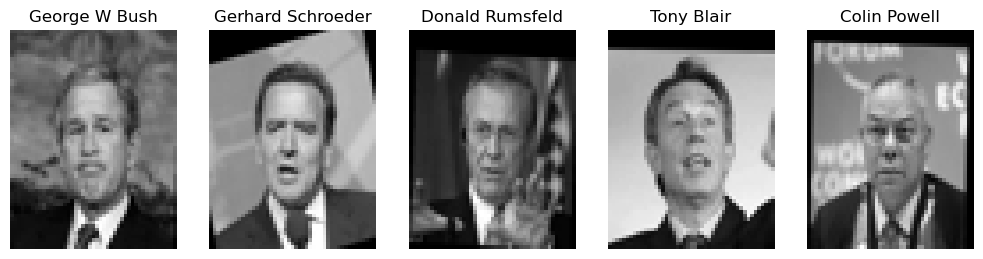

In [17]:
examples = list()
aux = 0
fig = plt.figure(figsize=(15,15))

while len(examples) != (max(images.target) + 1):

    if images.target[aux] not in examples:
        fig.add_subplot(1, 6, len(examples) + 1)
        examples.append(images.target[aux])

        plt.title(images.target_names[images.target[aux]])
        plt.imshow(images.images[aux], cmap='gray')
        plt.axis('off')

    aux = aux + 1

**4.3** Divide the dataset into train and test set (0.7/0.3). 

Hint: use the train_test_split function.

In [18]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(images.data, images.target, test_size = 0.3)

## 5. Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.

**5.1** Create a PCA object, using the training set and a 150 components

In [19]:
x = PCA(n_components=150).fit(X_train)

Plot the accumated variance of the components. 

**Hint:** Use the returned `explained_variance_ratio_`.

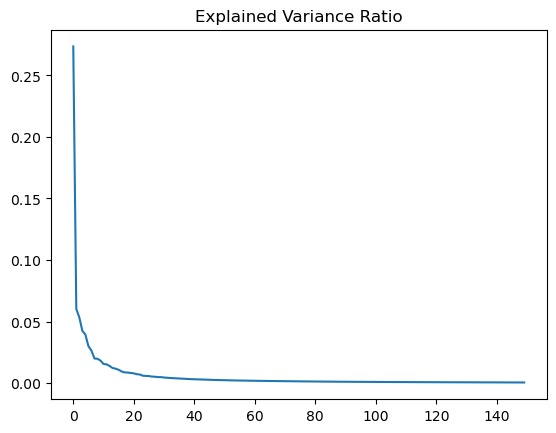

In [20]:
#your solution
plt.plot(x.explained_variance_ratio_)
plt.title('Explained Variance Ratio')
plt.show()

**5.2** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly

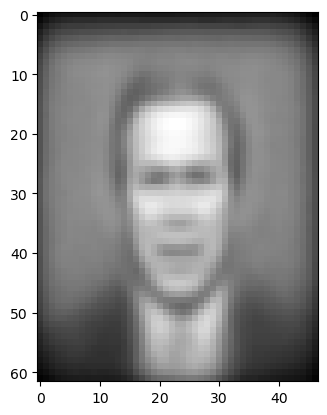

In [21]:
average_face = x.mean_.reshape(images.images[0].shape)

plt.imshow(average_face, cmap='gray')
plt.show()

**5.3** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance. Visualize 30 principal eigenfaces.

<img src="notebook_images/eigenfaces.png" width=600, height=300>

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc...

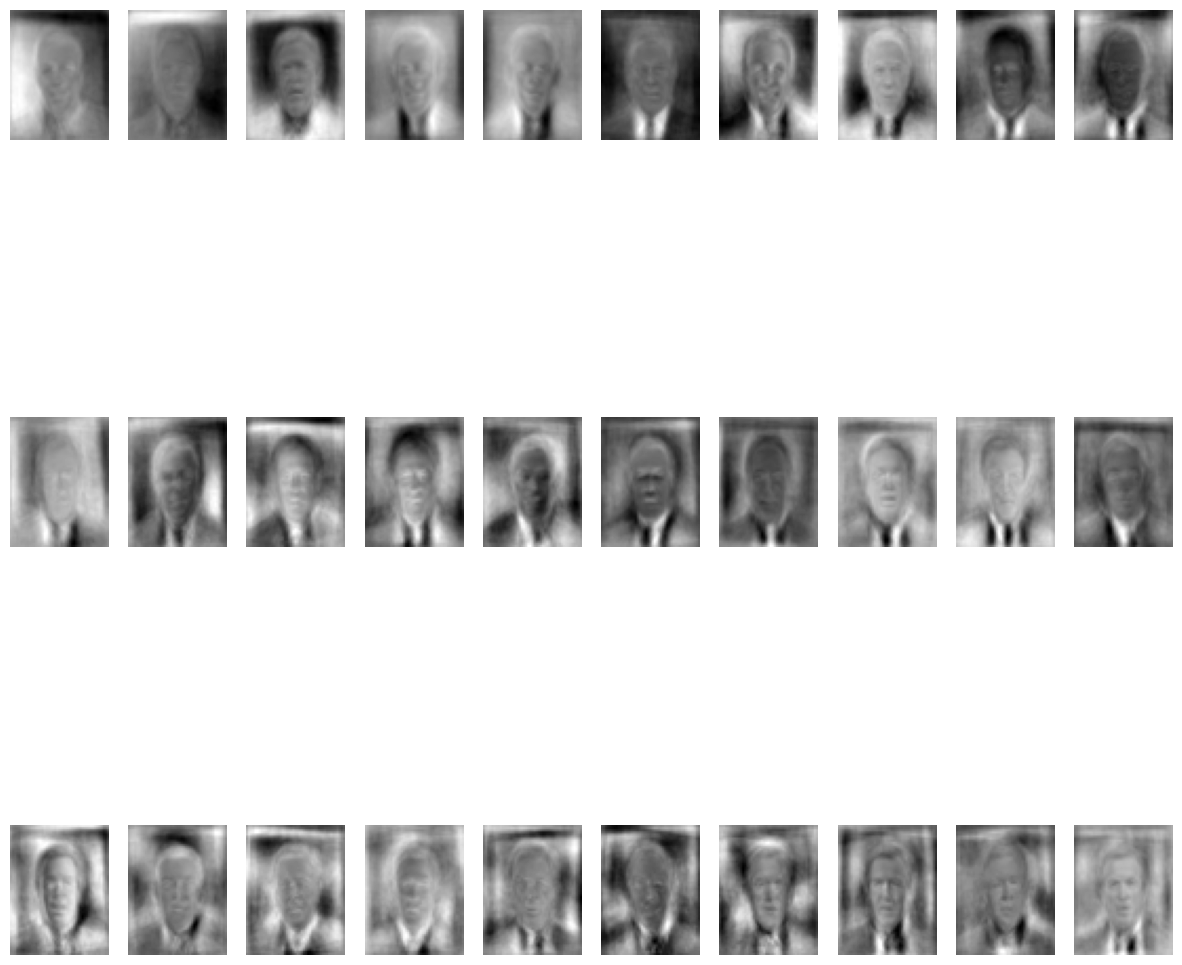

In [22]:
fig = plt.figure(figsize=(15,15))
for i in range(30):
    eigenface = x.components_[i+1].reshape(images.images[0].shape)
    fig.add_subplot(3, 10, i+1)
    plt.imshow(eigenface, cmap='gray')
    plt.axis('off')

**5.4** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

In [23]:
X_train_pca = x.transform(X_train)
X_test_pca = x.transform(X_test)

print(X_train.shape)
print(X_train_pca.shape)

print(X_test.shape)
print(X_test_pca.shape)

(798, 2914)
(798, 150)
(342, 2914)
(342, 150)


Do you need to apply the same to the variable y?

No, because the variable y does not have a dataset.

**5.5**  These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and try to recompose from its first 10 most important corresponding eigenfaces. **Note that** we need to use the average face as the basis to agregate the rest of the components.


<img src="notebook_images/eigenfaces_image.PNG" width=300, height=300>


## 6. Train a classifier

**6.1** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [24]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
clf.fit(X_train_pca, y_train)
acc = clf.score(X_test_pca, y_test)
print('Accuracy obtained with AdaBoostClassifier: ', acc)

Accuracy obtained with AdaBoostClassifier:  0.4619883040935672


**6.2** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [25]:
from sklearn.metrics import classification_report 

y_pred = clf.predict(X_test_pca)

report = classification_report(
    y_test,
    y_pred,
    labels=None,
    target_names=None,
    sample_weight=None,
    digits=2,
    output_dict=False,
    zero_division='warn'
)

print(report)

              precision    recall  f1-score   support

           0       0.42      0.29      0.34        69
           1       0.42      0.14      0.21        36
           2       0.49      0.79      0.61       156
           3       0.78      0.23      0.35        31
           4       0.10      0.04      0.06        50

    accuracy                           0.46       342
   macro avg       0.44      0.30      0.31       342
weighted avg       0.44      0.46      0.41       342



Please, explaing what is:
- accuracy (score)
- precision
- recall
- f1-score
- support
- macro avg
- weighted avg?


- accuracy (score): The number of correct predictions over by the total number of predictions.
- precision: Percentage of correct positive predictions relative to total positive predictions.
- recall: Percentage of correct positive predictions relative to total actual positives.
- f1-score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.
- support: Number of players belonged to each class in the dataset.
- macro avg: Arithmetic mean of all the per-class F1 scores.
- weighted avg?: Mean of all per-class F1 scores while considering each class’s support.

**6.3** Train an Adaboost classifier, without PCA, using the training set. Show the results using the `score` method of the Adaboost model and the corresponding classification report.

In [26]:
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier()
classifier.fit(X_train, y_train)
accuracy = classifier.score(X_test, y_test)

print('Accuracy obtained with AdaBoostClassifier: ', accuracy)

Accuracy obtained with AdaBoostClassifier:  0.4298245614035088


**Questions**

- Does computing time change using PCA? How?
- Which of both (with and without PCA) does give better results?
- How does the result change if we change the number of components in PCA?
- How does the result change if we change the number of estimators in the Adaboost?

- Does computing time change using PCA? How?

The computing time decreases using PCA because it uses a lower proportion of the dataset rather than the classifier that not uses PCA.

- Which of both (with and without PCA) does give better results?

The PCA one gives a better result, giving an accuracy 10 % better.

- How does the result change if we change the number of components in PCA?

- How does the result change if we change the number of estimators in the Adaboost?

**6.4 (Optional)** Repeat the experiment using a different number of components. 

For instance, instead of using 150 components, try using 10, 25, 50, 200, 500... at your election. These numbers are just orientative. 

- How much variance is acummulated using the different number of components.
- The result is better using... how many components? 
- Does time change using a different numbero of components?

## 7. Recognize a new face example using the learned model

**7.1** Try your both models using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="notebook_images/prediction.png" width=300 height = 300>

In [27]:
'''
AUXILIAR FUNCTIONS
'''

def title(y_pred, y_test, target_names, i):
    '''
    This functions plots the result of the 
    prediction on a portion of the test set
    '''
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    '''
    Qualitative evaluation of the predictions using matplotlib
    
    '''
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

Predicting people's names on the test set without PCA


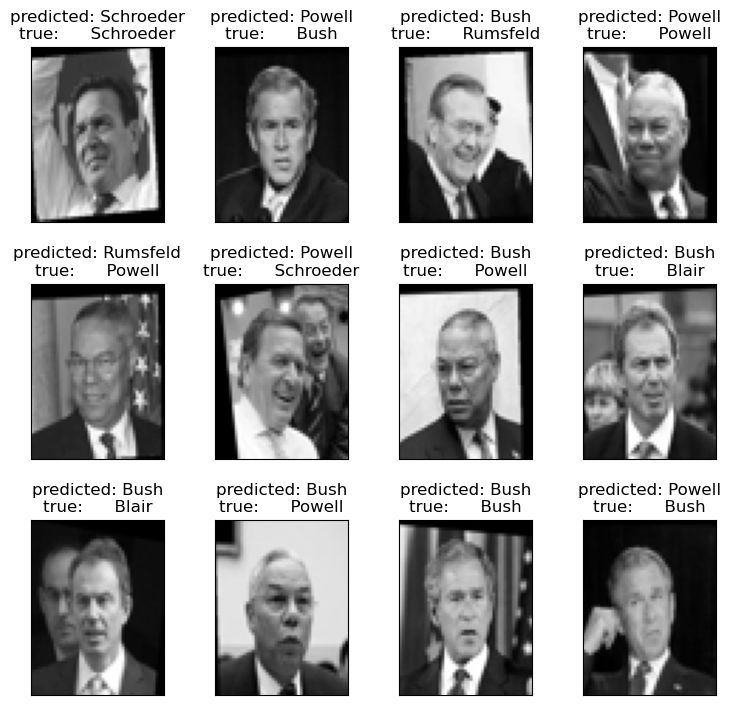

In [28]:
# Quantitative evaluation of the model quality on the test set
print("Predicting people's names on the test set without PCA")

x = PCA(n_components=150).fit(X_train) # here we use the train set without pca
classifier = AdaBoostClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) # here we use the test set without pca
target_names = images.target_names
eigenfaces = x.components_
n_samples, h, w = images.images.shape

# we create the array with the titles
pred_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

# plot the gallery of the most significative eigenfaces
plot_gallery(X_test, pred_titles, h, w)
plt.show()

Predicting people's names on the test set with PCA


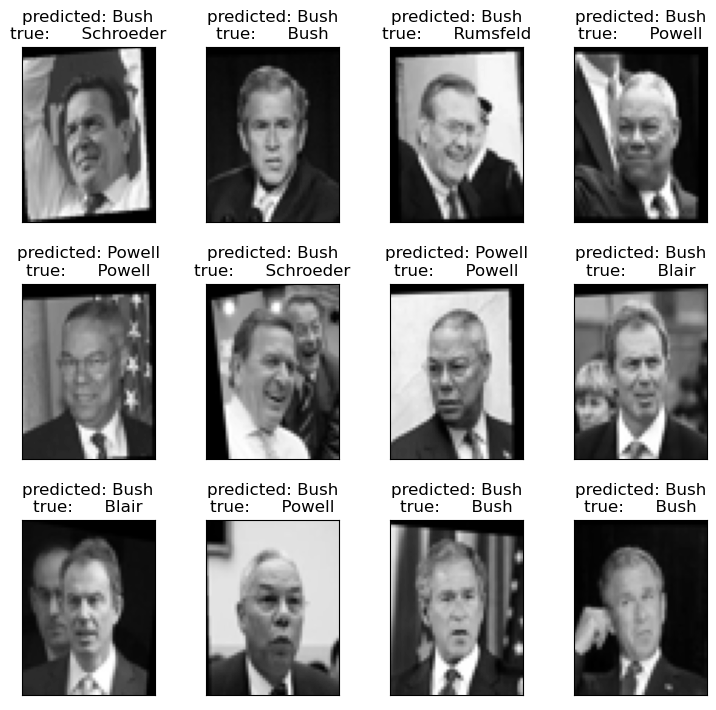

In [29]:
# Quantitative evaluation of the model quality on the test set
print("Predicting people's names on the test set with PCA")

x = PCA(n_components=150).fit(X_train_pca) # here we use the train set with pca
classifier = AdaBoostClassifier()
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_test_pca) # here we use the test set with pca
target_names = images.target_names
eigenfaces = x.components_
n_samples, h, w = images.images.shape

# we create the array with the titles
pred_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

# plot the gallery of the most significative eigenfaces
plot_gallery(X_test, pred_titles, h, w)
plt.show()

Which model makes the predictions better? Try different parameters and comment their effect on the model performance.

Without PCA we have 3 out of 12 right predictions and with the one with PCA we have 5 out of 12 right predictions, both with n_components = 150. So with PCA it gets more matches</p>
We tried descending the n_components and we realized that there were less matches, specially in the first test with no pca.</p>
We also tried using other parameters such as whiten(False by default) and copy(True by default) we didnt apreciate any difference. There are more parameters like:</p>
<dl>
<dt><b>copy: </b></dt>
    <dd>If False, data passed to fit are overwritten and running fit(X).transform(X) will not yield the expected results, use fit_transform(X) instead.</dd>
<dt><b>whiten: </b></dt>
    <dd>When True (False by default) the components_ vectors are multiplied by the square root of n_samples and then divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.</dd>
<dt><b>svd_solver:</b></dt>
    <dd><b>If auto: </b>
    The solver is selected by a default policy</dd>
    <dd><b>If full: </b>
    run exact full SVD calling the standard LAPACK solver via scipy.linalg.svd and select the components by postprocessing</dd>
    <dd><b>If arpack: </b>
    run SVD truncated to n_components calling ARPACK solver via scipy.sparse.linalg.svds. It requires strictly 0 < n_components < min(X.shape)</dd>
    <dd><b>If randomized: </b>
    run randomized SVD by the method of Halko et al.</dd>
<dt><b>tol: </b></dt>
    <dd>Tolerance for singular values computed by svd_solver == ‘arpack’. Must be of range [0.0, infinity).</dd>
<dt><b>iterated_power: </b></dt>
    <dd>Number of iterations for the power method computed by svd_solver == ‘randomized’. Must be of range [0, infinity).</dd>
<dt><b>n_oversamples (default = 10): </b></dt>
    <dd>This parameter is only relevant when svd_solver="randomized". It corresponds to the additional number of random vectors to sample the range of X so as to ensure proper conditioning.</dd>
<dt><b>power_iteration_normalizer ({‘auto’, ‘QR’, ‘LU’, ‘none’}, default=’auto’): </b></dt>
    <dd>Power iteration normalizer for randomized SVD solver. Not used by ARPACK.</dd>
<dt><b>random_stateint (RandomState instance or None, default=None): </b></dt>
    <dd>Used when the ‘arpack’ or ‘randomized’ solvers are used. Pass an int for reproducible results across multiple function calls. See Glossary.</dd>
</dl>